In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.fit_psf import *
from decode_fish.funcs.dataset import EstimateBackground

from decode_fish.engine.psf import LinearInterpolatedPSF

In [2]:
path_tif = Path('//groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_3.tif')
bead_vol = load_tiff_image(path_tif)
estimate_backg = EstimateBackground(20, 1)
print(bead_vol.shape)

torch.Size([1, 37, 512, 512])


In [3]:
bead_vol_no_bg = bead_vol - estimate_backg(bead_vol)

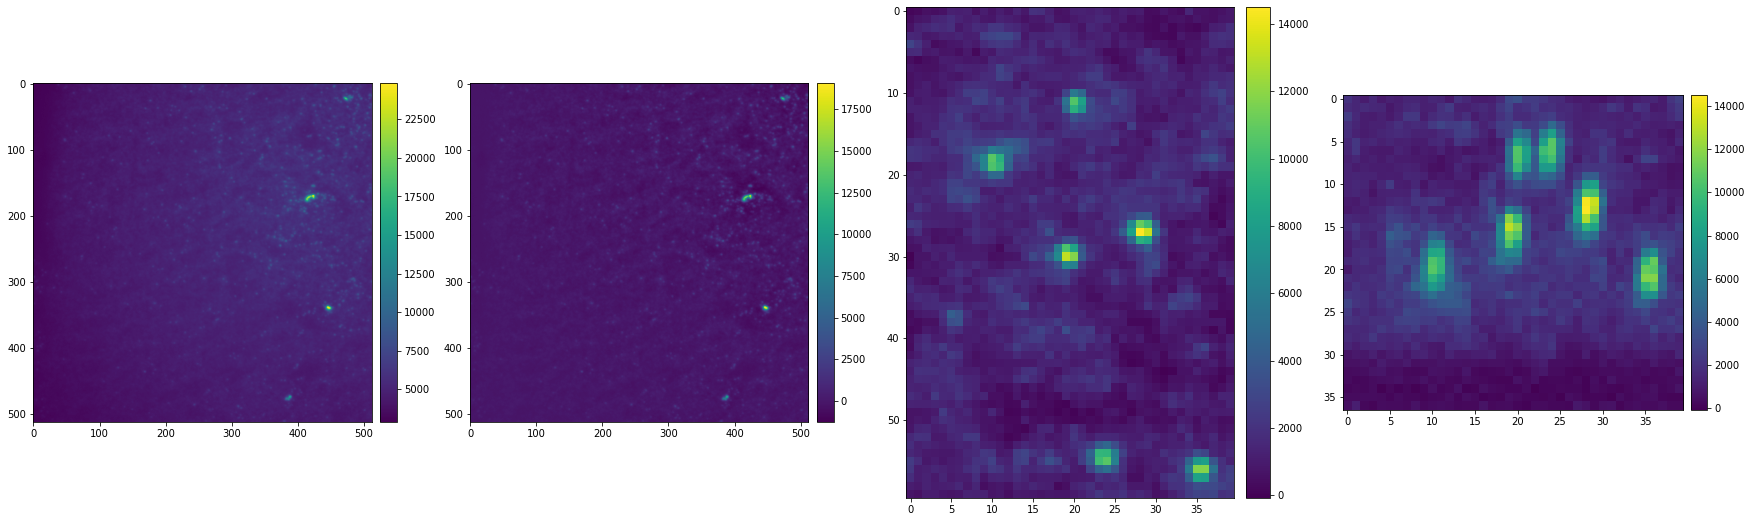

In [4]:
win_sl = np.s_[0,:,40:100,360:400]

plt.figure(figsize=(30,10))
plt.subplot(141)
im = plt.imshow(bead_vol[0].mean(0))
add_colorbar(im)
plt.subplot(142)
im = plt.imshow(bead_vol_no_bg[0].mean(0))
add_colorbar(im)
plt.subplot(143)
im = plt.imshow(bead_vol_no_bg[win_sl].max(0).values)
add_colorbar(im)
plt.subplot(144)
im = plt.imshow(bead_vol_no_bg[win_sl].max(1).values)
add_colorbar(im)

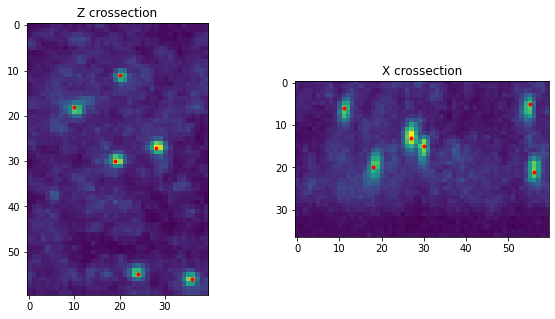

In [5]:
coords_xyz = get_peaks_3d(bead_vol_no_bg[win_sl], threshold=5000, min_distance=5)
plot_detection(bead_vol_no_bg[win_sl], coords_xyz)

In [6]:
abs_coords_xyz = np.array([c + np.array([int(win_sl[3].start or 0), int(win_sl[2].start or 0), int(win_sl[1].start or 0)]) for c in coords_xyz])

In [7]:
rois = extract_roi(bead_vol_no_bg, abs_coords_xyz, size_xy=7, size_z=7)

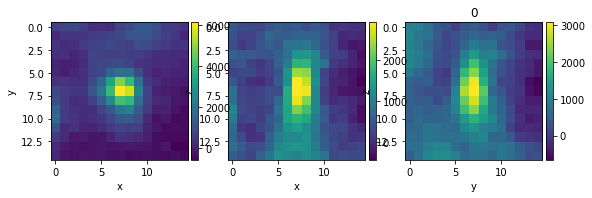

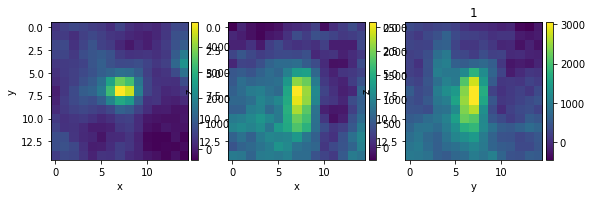

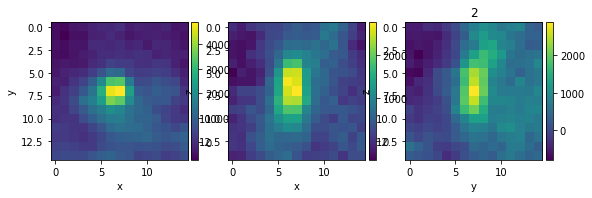

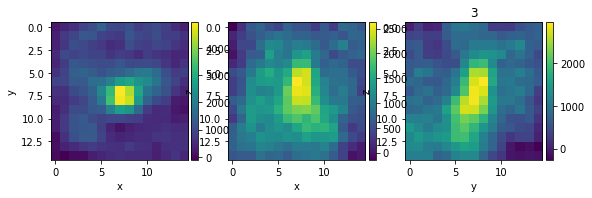

In [20]:
for i in range(len(rois)): 
    plot_3d_projections(rois[i], projection='mean', size=3);
    plt.title(i)

In [21]:
print(rois.shape)
rois_clean = rois
rois_normed = rois_clean/rois_clean.sum(-1).sum(-1).sum(-1)[:,None,None,None] * 100

extend = [0,3,3,3]
rois_extended = torch.zeros([s + 2*e for s,e in zip(rois_normed.shape,extend)])
rois_extended[:,extend[1]:-extend[1],extend[2]:-extend[2],extend[3]:-extend[3]] = rois_normed

torch.Size([4, 15, 15, 15])


In [22]:
device='cuda'
PSF = LinearInterpolatedPSF(rois_extended.shape[-3:],1, device=device)

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


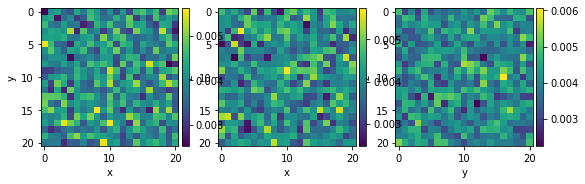

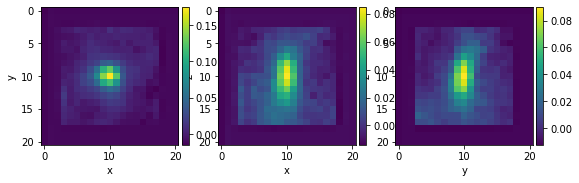

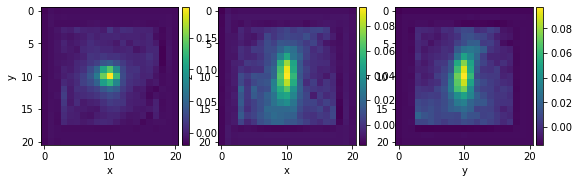

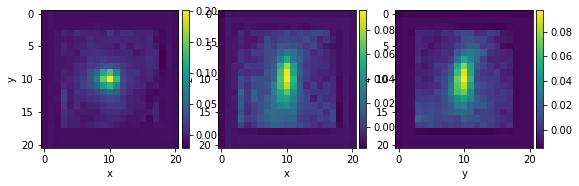

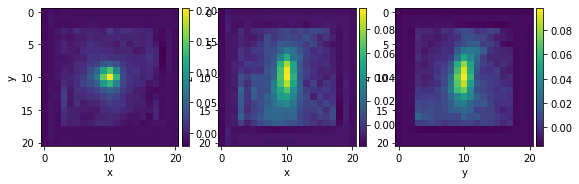

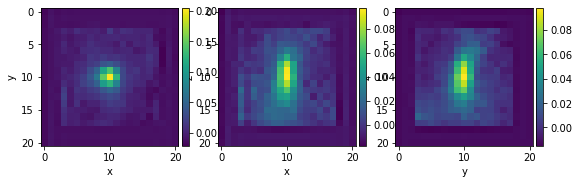

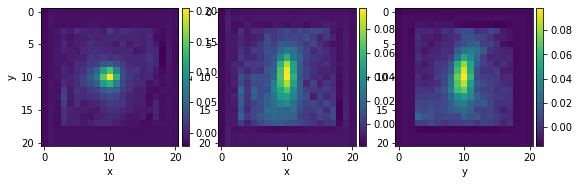

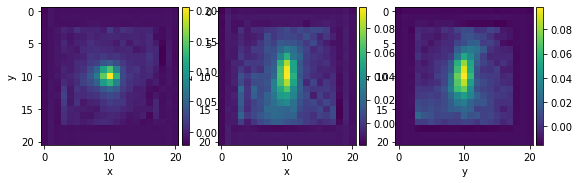

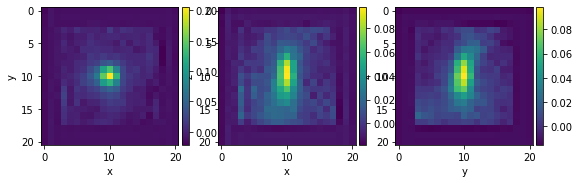

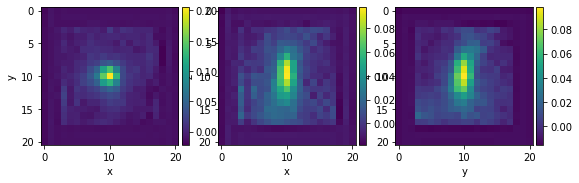

In [23]:
loss_res = fit_psf(PSF, rois_extended)

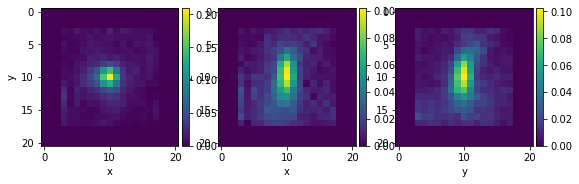

In [24]:
plot_3d_projections(torch.clamp_min(PSF.psf_volume[0],0), projection='mean', size=3);

In [25]:
PSF.psf_volume.data = torch.clamp_min_(PSF.psf_volume.data, 0) 

Text(0.5, 1.0, '0.00046990494593046606')

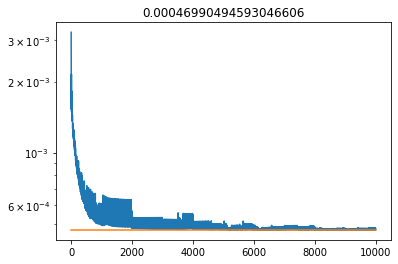

In [26]:
plt.plot(loss_res)
plt.yscale('log')
plt.plot([0,10000],[np.min(loss_res),np.min(loss_res)])
plt.title(np.min(loss_res))

In [27]:
torch.save(PSF.state_dict(), 'data/msp300_smFISH_3.pkl')